In [ ]:
#==============================================================================
# Configure GPU acceleration for TensorFlow for faster training 
#==============================================================================

import os
import sys
import subprocess
import tensorflow as tf

# Install TensorFlow-MacOS and Metal GPU acceleration
def install_tensorflow_m1():
    """
    Uninstalls existing TensorFlow and installs Apple Silicon optimized TensorFlow
    with Metal Performance Shaders (MPS) for GPU acceleration on macOS.
    """
    print("🔄 Uninstalling any existing TensorFlow versions...")
    subprocess.run(["pip", "uninstall", "-y", "tensorflow", "tensorflow-macos", "tensorflow-metal"], check=True)

    print("\n⬇️ Installing TensorFlow-MacOS and Metal GPU acceleration...")
    subprocess.run(["pip", "install", "tensorflow-macos", "tensorflow-metal"], check=True)

    print("\n✅ Installation complete! Please restart your Jupyter Notebook kernel now.")

    """
    - Function taken from: Chat-GPT
    """

install_tensorflow_m1()

🔄 Uninstalling any existing TensorFlow versions...
Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2
Found existing installation: tensorflow-macos 2.16.2
Uninstalling tensorflow-macos-2.16.2:
  Successfully uninstalled tensorflow-macos-2.16.2
Found existing installation: tensorflow-metal 1.2.0
Uninstalling tensorflow-metal-1.2.0:
  Successfully uninstalled tensorflow-metal-1.2.0

⬇️ Installing TensorFlow-MacOS and Metal GPU acceleration...
  Using cached tensorflow_macos-2.16.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached tensorflow_metal-1.2.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (1.3 kB)
  Using cached tensorflow-2.16.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.1 kB)
Using cached tensorflow_macos-2.16.2-cp312-cp312-macosx_12_0_arm64.whl (2.1 kB)
Using cached tensorflow-2.16.2-cp312-cp312-macosx_12_0_arm64.whl (227.1 MB)
Using cached tensorflow_metal-1.2.0-cp312-cp312-macosx_12_0_

In [ ]:
#GPU Check
def check_tensorflow_gpu():
    """
    Checks if TensorFlow correctly detects the GPU on an Apple M1/M2/M3 Mac.
    """
    print("\n🔎 Checking TensorFlow and GPU availability...\n")
    
    print("TensorFlow version:", tf.__version__)
    print("Available devices:", tf.config.list_physical_devices())

    gpu_devices = tf.config.list_physical_devices('GPU')
    
    if gpu_devices:
        print("\n✅ GPU is available! TensorFlow will use the M1/M2/M3 GPU.")
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)  # Manage GPU memory efficiently
    else:
        print("\n⚠️ No GPU detected! TensorFlow is running on CPU.")
        print("   Try restarting the kernel and running this cell again.")
    
    """
    - Function taken from: Chat-GPT
    """

check_tensorflow_gpu()



🔎 Checking TensorFlow and GPU availability...

TensorFlow version: 2.16.2
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ GPU is available! TensorFlow will use the M1/M2/M3 GPU.


*Based on this output, the GPU will be used to train the model and make the process more efficient, since TensorFlow has successfully detected and assigned the computer's GPU as a computational device, allowing matrix operations and deep learning computations to be accelerated compared to CPU-only training. This results in faster training times, especially for convolutional neural networks*

In [2]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [39]:
import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.16.2
3.8.0


In [5]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data", channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


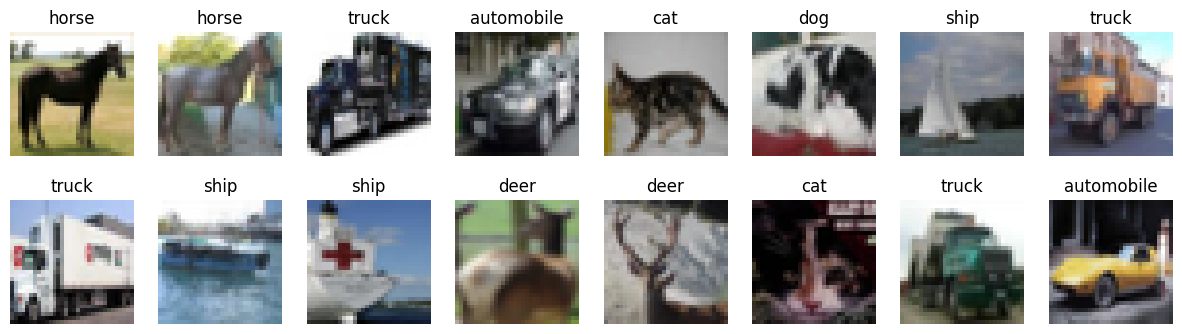

In [6]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
#==============================================================================
# Data Augmentation
#==============================================================================

# Create and configure augmented image generator to expand training dataset using imagedatagenerator class  
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,           # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,       # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1,      # Shift images vertically by up to 10% of the height
    horizontal_flip=True,        # Randomly flip images horizontally
    zoom_range=[0.8, 1.2],       # Randomly zoom in/out between 80% and 120%
    fill_mode='reflect'          # Fill in missing pixels with reflections
)

This code creates an image data generator using Keras's ImageDataGenerator class to perform data augmentation, in order to artificially expand the training dataset by creating slightly modified versions of existing images. This helps the neural network generalize better and reduces overfitting.

Specifically, it applies the following transformations randomly to the images during training:
- Rotation: Images are randomly rotated up to ±15 degrees.
- Width and Height shifts: Images are shifted horizontally and vertically by up to 10% of their size, helping the model become invariant to minor positional variations.
- Horizontal Flip: Images can be randomly flipped horizontally, which is helpful when the direction doesn't impact the recognition, since the set of images do not depend on differentiating left from right of any object.
- Zooming: Images can be randomly zoomed in or out between 80% and 120% of their original size, improving robustness to scale variations.
- Reflection (fill_mode): Areas that become empty after applying these transformations are filled using reflections of the existing pixels, avoiding unnatural blank spots.

Together, these augmentations improve the model’s ability to learn diverse and realistic variations of the training images, ultimately resulting in higher accuracy on unseen data.

In [9]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU, BatchNormalization, GlobalAveragePooling2D, Input
from keras.regularizers import l2

In [ ]:
#==============================================================================
# Model Building
#==============================================================================

def make_model(arg_input_shape=(32, 32, 3), k_size=(3, 3)):
    """
    Builds a deep convolutional neural network for image classification.

    Model architecture: see Markdown below

    Parameters:
    - arg_input_shape: Tuple defining the input image dimensions (default: CIFAR-10 size: 32x32x3).
    - k_size: Kernel size for convolutional layers (default: (3,3)).

    Returns:
    - model: A compiled Keras Sequential model ready for training.
    """

    # Define pooling size dynamically based on the kernel size
    p_size = (k_size[0]-1, k_size[1]-1)

    # Initialize Sequential model
    model = Sequential()

    # Input Layer (Ensures proper input format and avoids warnings)
    model.add(Input(shape=arg_input_shape))  # Input shape for CIFAR-10 images (32,32,3)

    # Block 1: First convolutional block
    model.add(Conv2D(32, kernel_size=k_size, padding='same'))  # First Conv Layer with 32 filters
    model.add(LeakyReLU(negative_slope=0.1))  # Leaky ReLU activation to prevent dying neurons
    model.add(BatchNormalization())  # Normalizes activations to stabilize training

    model.add(Conv2D(32, kernel_size=k_size, padding='same'))  # Second Conv Layer with 32 filters
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=p_size))  # Pooling layer reduces spatial size
    model.add(Dropout(0.2))  # Dropout layer (20%) to prevent overfitting

    # Block 2: Second convolutional block
    model.add(Conv2D(64, kernel_size=k_size, padding='same'))  # Conv Layer with 64 filters
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(64, kernel_size=k_size, padding='same'))  # Second Conv Layer with 64 filters
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=p_size))
    model.add(Dropout(0.2))

    # Block 3: Third convolutional block
    model.add(Conv2D(128, kernel_size=k_size, padding='same'))  # Conv Layer with 128 filters
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=k_size, padding='same'))  # Second Conv Layer with 128 filters
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=p_size))
    model.add(Dropout(0.2))

    # Flattening before fully connected layers
    model.add(Flatten())  # Converts feature maps into a 1D vector

    # Fully connected layers with L2 Regularization
    model.add(Dense(256, kernel_regularizer=l2(0.001)))  # 256 neurons, L2 Regularization to prevent overfitting
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Dropout (50%) for strong regularization

    model.add(Dense(128, kernel_regularizer=l2(0.001)))  # 128 neurons, L2 Regularization
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.3))  # Dropout (30%) to prevent overfitting

    # Output Layer
    model.add(Dense(10, activation='softmax'))  # 10 output classes (CIFAR-10 categories)

    return model

### *Model Architecture:*

| **Block**               | **Layer Type**      | **Number of Filters** | **Kernel Size** | **Activation** | **Regularization** | **Additional Features** |
|------------------------|-------------------|-----------------|--------------|------------|----------------|---------------------|
| <font color="green">**Input Layer**</font>      | Input             | -               | -            | -          | -              | Input: (32, 32, 3) |
|                        |                   |                 |              |            |                |                     |
| <font color="blue">**Convolutional Block 1**</font> | Conv2D           | 32              | (3,3)        | LeakyReLU  | -              | BatchNorm |
|                        | Conv2D           | 32              | (3,3)        | LeakyReLU  | -              | BatchNorm |
|                        | MaxPooling2D     | -               | (2,2)        | -          | -              | Dropout (20%) |
|                        |                   |                 |              |            |                |                     |
| <font color="blue">**Convolutional Block 2**</font> | Conv2D           | 64              | (3,3)        | LeakyReLU  | -              | BatchNorm |
|                        | Conv2D           | 64              | (3,3)        | LeakyReLU  | -              | BatchNorm |
|                        | MaxPooling2D     | -               | (2,2)        | -          | -              | Dropout (20%) |
|                        |                   |                 |              |            |                |                     |
| <font color="blue">**Convolutional Block 3**</font> | Conv2D           | 128             | (3,3)        | LeakyReLU  | -              | BatchNorm |
|                        | Conv2D           | 128             | (3,3)        | LeakyReLU  | -              | BatchNorm |
|                        | MaxPooling2D     | -               | (2,2)        | -          | -              | Dropout (20%) |
|                        |                   |                 |              |            |                |                     |
| <font color="red">**Fully Connected Layers**</font> | Flatten          | -               | -            | -          | -              | Converts feature maps to 1D |
|                        | Dense            | 256             | -            | LeakyReLU  | L2 (0.001)     | BatchNorm, Dropout (50%) |
|                        | Dense            | 128             | -            | LeakyReLU  | L2 (0.001)     | Dropout (30%) |
|                        |                   |                 |              |            |                |                     |
| <font color="orange">**Output Layer**</font>    | Dense            | 10              | -            | Softmax    | -              | 10-class classification |


The model takes RGB images (32x32 pixels, 3 color channels) as input. First, it uses convolutional layers to detect basic features (edges, colors, textures), followed by LeakyReLU activation, Batch Normalization, and pooling layers to simplify the representation.

Next, additional convolutional blocks with progressively more filters (32, 64, 128) extract increasingly detailed and complex patterns from the images. Each block includes Batch Normalization and Dropout to prevent overfitting. Batch normalization helps stabilize the training process by keeping activations within a standard range, leading to faster and smoother training. Dropout randomly disables some neurons during training, forcing the network to learn more robust and generalized features, preventing overfitting.

After convolutional blocks, the data is flattened into a single-dimensional vector. Fully connected layers (Dense layers) then learn combinations and relationships between these features. L2 regularization, Batch Normalization, and Dropout are applied here as well. L2 regularization penalizes large weights, encouraging the model to keep weights smaller, further reducing overfitting and improving generalization.

Finally, the output layer uses a softmax activation function, which outputs probabilities for each of the 10 classes from the images. The model predicts the class corresponding to the highest probability.


In [71]:
# print summary of the model
make_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 848,554 (3.24 MB)

 Trainable params: 847,146 (3.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

*The model contains approximately 850,000 parameters, with nearly all of them being trainable.*

In [ ]:
#==============================================================================
# Model Training
#==============================================================================

INIT_LR = 1e-3   # Initial learning rate
BATCH_SIZE = 64  
EPOCHS = 100

K.clear_session()  # clear default graph

model = make_model()  # define our model

# Early stopping callback to prevent unnecessary training
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',   # Stop training if no improvement in validation accuracy
    patience=10,           # Number of epochs to wait before stopping
    restore_best_weights=True,  # Restore model to best state when stopping
    verbose=1
)

# Learning rate scheduler that dynamically reduces learning rate during training based on Validation Loss
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitors validation loss
    factor=0.5,          # Reduce LR by 50% (new_lr = old_lr * 0.5)
    patience=3,          # Wait 3 epochs before reducing LR
    min_lr=1e-6,         # Minimum learning rate limit
    verbose=1            # Print updates
)


# Prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),  # Adam optimizer for adaptive learning
    metrics=['accuracy']  # report accuracy during training
)

# fit model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), # Data generator applies augmentation of training data in real-time
    #x_train, y_train,  # Use original data, no modifications
    #batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_train) // BATCH_SIZE,  # Number of batches per epoch
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, lr_scheduler], # Early stopping and learning rate scheduler
    shuffle=True,
    verbose=1,
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")


Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 69ms/step - accuracy: 0.3000 - loss: 2.7593 - val_accuracy: 0.4925 - val_loss: 1.9140 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.4939 - loss: 1.8384 - val_accuracy: 0.5627 - val_loss: 1.6440 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.5813 - loss: 1.4822 - val_accuracy: 0.6205 - val_loss: 1.3141 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6238 - loss: 1.2980 - val_accuracy: 0.7006 - val_loss: 1.0838 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6576 - loss: 1.1986 - val_accuracy: 0.7230 - val_loss: 0.9809 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.6845 - loss: 1.1228 - val_accuracy: 0.7197 - val_loss: 1.0429 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - accuracy: 0.7

The model is compiled using the Adam optimizer with an initial learning rate of 0.001.
During training, two callbacks are used to improve performance and efficiency:
- EarlyStopping (early_stop):
    Stops training early if the validation accuracy doesn't improve for 10 epochs, preventing overfitting and unnecessary computation. It also restores the weights from the epoch where the best validation accuracy occurred.
- ReduceLROnPlateau (lr_scheduler):
    Monitors validation loss, and if no improvement is seen for 3 consecutive epochs, it reduces the learning rate by half. This allows the model to fine-tune learning once performance plateaus, ultimately helping the model converge better. The learning rate never goes below a minimal threshold (1e-6).

After training:
- The model began training with an initial accuracy of about 30%, and quickly improved its ability to classify images correctly over epochs.
- Accuracy improved steadily, eventually surpassing 87% on the training set and around 89% on the validation set, indicating strong performance.
- Simultaneously, the validation loss (how well the model predicts unseen data) steadily decreased, showing the model learned robust features from the data.
- EarlyStopping stopped training automatically when there was no significant improvement after 10 epochs. This occurred at epoch 71, indicating the model had reached a performance plateau.
- The best epoch happened at epoch 63, with a validation accuracy of 0.8942.
- The final learing rate set by the ReduceLROnPlateau was 3.9063e-06. 

In [74]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

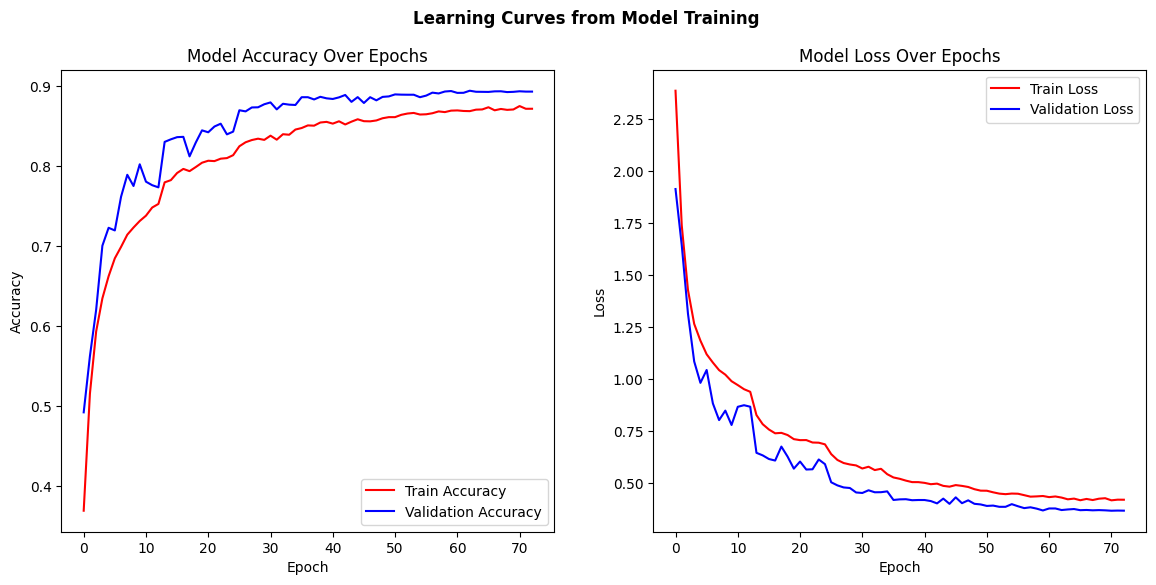

In [84]:
#==============================================================================
# Learning Curves Plotting
#==============================================================================

plt.figure(figsize=(14, 6))
plt.suptitle("Learning Curves from Model Training", fontweight='bold')

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot training & validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

These learning curves provide a clear visual understanding of the training process and performance of the model:

- Accuracy Curve:
    Both training and validation accuracy consistently increase and then stabilize, suggesting that the model is learning effectively. The validation accuracy slightly exceeds the training accuracy, which indicates a good generalization capability of the model. After around epoch 30-40, accuracy growth slows down and reaches a plateau near 89%. This suggests the model has captured most of the relevant features from the data.
- Loss Curve:
    Both the training and validation loss curves show a smooth, steady decline, indicating effective learning without signs of significant overfitting or underfitting, since both training an validation values are similar. Validation loss closely tracks the training loss and ends up slightly lower. This means the model generalizes well, adapting effectively to new, unseen data.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


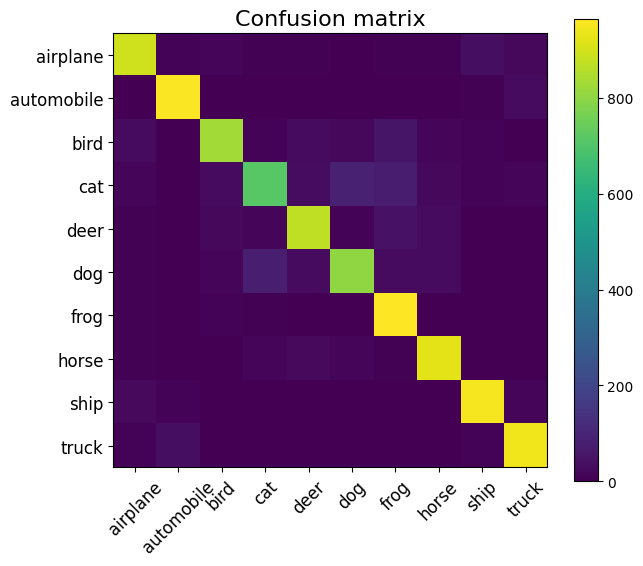

Test accuracy: 0.8855


In [118]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()

print(f"\033[1mTest accuracy:\033[0m \033[0;32;1m{accuracy_score(y_test_index, y_pred_test_classes)}\033[0m")

The model achieved a final test accuracy of <font color="green">88.55%</font>, indicating strong predictive capability and effective generalization on previously unseen data.

The confusion matrix provides a clear visualization of the model’s predictions. It shows a strong diagonal pattern, which indicates that the model successfully classifies most images into the correct classes (airplanes as airplanes, frogs as frogs, and so on...). High values along the diagonal and low values elsewhere suggest that the model makes relatively few misclassifications.

However, the off-diagonal values, while small, indicate some classes that the model finds challenging or occasionally confuses. In this case we can see that the model struggles classifying animals, since they can have similar shapes or colors, causing occasional confusion. In this case we see that the model specially struggles classifying cats and dogs, since these two categories have lower "temperatures" in the diagonal matrix compared to the other categories. 

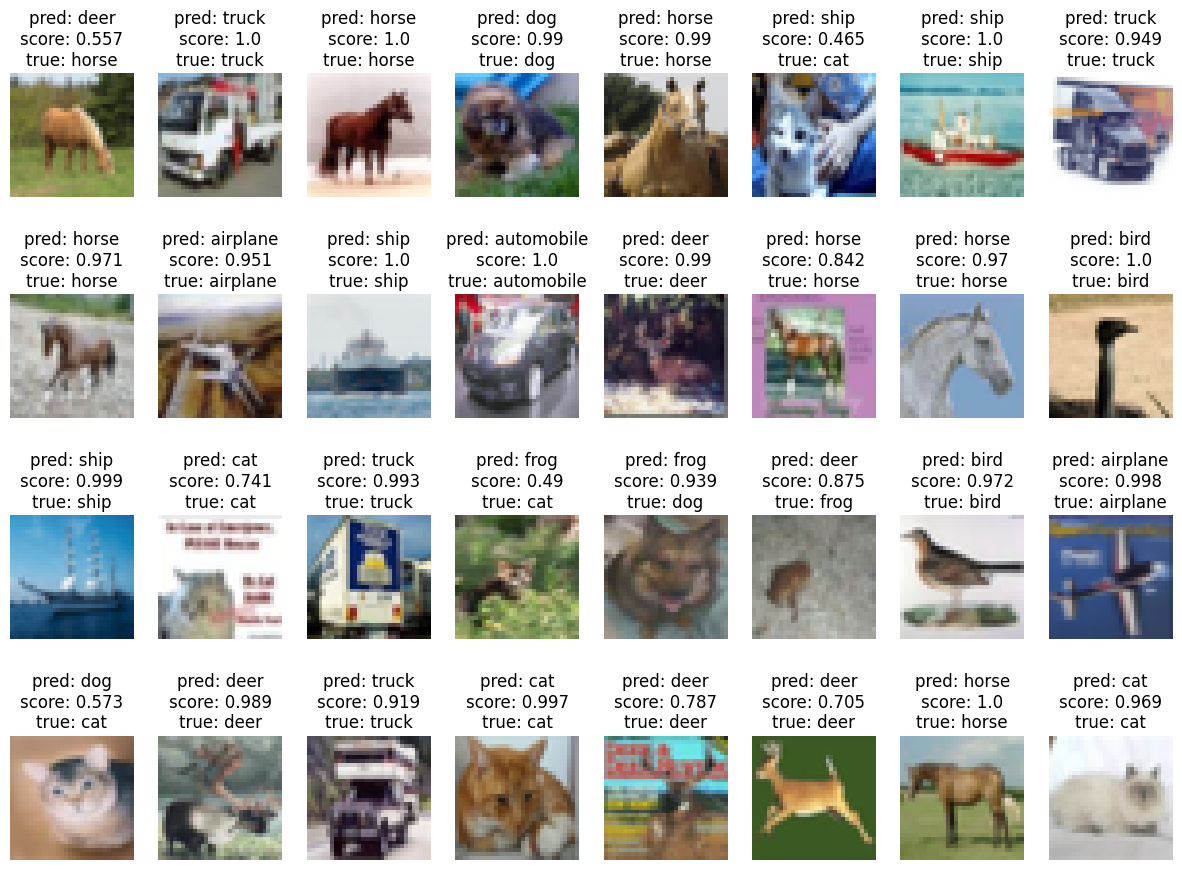

In [85]:
# inspect preditions
cols = 8
rows = 4
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

From this random sample of the models' predictions during testing, we can see that the model got most of the predictions correct. However we also see that the model did some mistakes when classifing animals, while it got all of the non-animal categories correct; which is expected as animals are more difficult to classify due to their similarities in shape and color. 

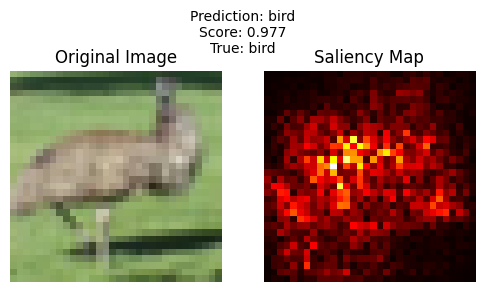

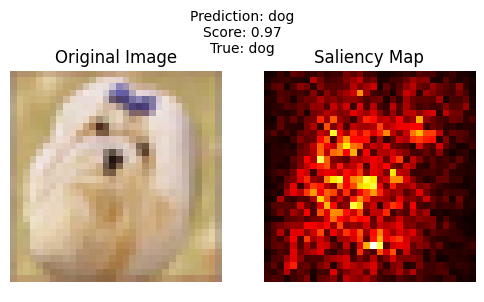

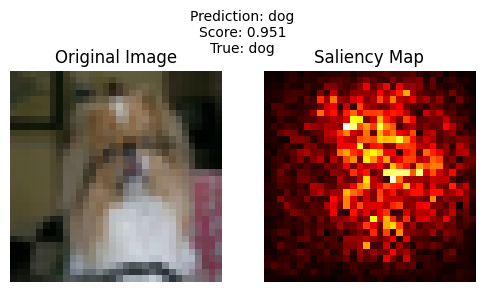

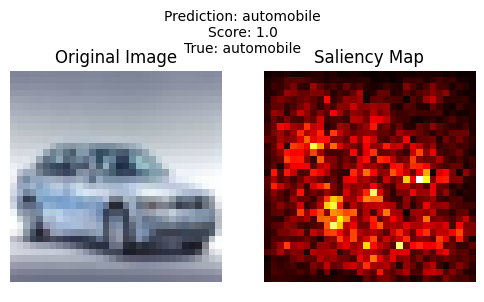

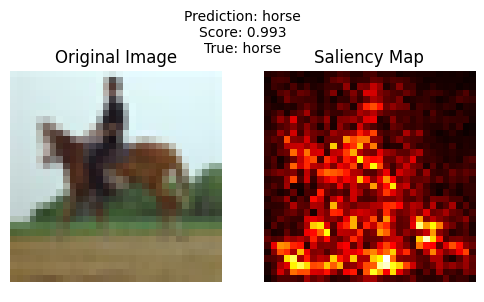

In [ ]:
#Create and plot saliency map for a given image to visually interpret what the neural network "sees" or considers important for its predictions.
def plot_saliency_map(model, image, label_index, random_index):
    
    """
    """
    image_tensor = tf.convert_to_tensor(image.reshape((1, 32, 32, 3)), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)            # Track gradients with respect to the input image
        predictions = model(image_tensor)   # Get model's predictions
        loss = predictions[:, label_index]  # Compute loss (activation) of the predicted class

    # Compute gradient of output class activation with respect to input image pixels
    gradients = tape.gradient(loss, image_tensor)[0]

    # Get absolute maximum gradient across color channels for saliency visualization
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)

    """
    - Taken from: Chat-GPT
    """

    # Plot results
    plt.figure(figsize=(6,3))

    pred_label = cifar10_classes[y_pred_test_classes[random_index]]
    pred_proba = y_pred_test_max_probas[random_index]
    true_label = cifar10_classes[y_test_index[random_index]]
    plt.title("Prediction: {}\nScore: {:.3}\nTrue: {}".format(pred_label, pred_proba, true_label), fontsize=10)
    plt.axis('off')

    # Original image 
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

    # Saliency map visualization
    plt.subplot(1, 2, 2)
    plt.title("Saliency Map")
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')

    plt.show()


for _ in range(5):
    index = np.random.randint(len(x_test))
    plot_saliency_map(model, x_test[index], y_pred_test_classes[index], index)


To better understand how the model works, we can use saliency maps. A saliency map visualizes the pixels in an image that the neural network relies on most heavily when making its predictions. It does this by calculating the gradient of the prediction (output neuron activation) with respect to the input image. Pixels with higher gradient values (brighter areas on the saliency map) significantly influence the model's decisions, indicating the features most relevant to the prediction.

From these samples of saliency maps created by the model, we can observe that the network learned how to roughly distinguish the shape and structure of objects by assigning higher importance to specific areas of the image. Bright spots on the saliency map typically outline the key visual features that guide the model's decision-making process, demonstrating that the model correctly focuses on the most relevant areas rather than background or irrelevant parts of the images.

This technique is extremely valuable as it allows us to confirm that the model's predictions are based on meaningful patterns, improving the confidence in the results and providing insights into areas where the model may need further improvement.

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


